In [1]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
import gsw
import xgcm

### Barotropic Transport Streamfunction
The barotropic velocity can be used to calculate the barotropic streamfunction, defined via

$u_b=-\frac{\partial \psi}{\partial y}$, $v_b=\frac{\partial \psi}{\partial x}$.

### Load data

In [2]:
datadir = '/data/home/liutongya/data/CMIP6/GFDL_CM4/vo/vo_Omon_GFDL-CM4_historical_r1i1p1f1_gn_199001-200912.nc'
dsv = xr.open_dataset(datadir)

datadir = '/data/home/liutongya/data/CMIP6/GFDL_CM4/uo/uo_Omon_GFDL-CM4_historical_r1i1p1f1_gn_199001-200912.nc'
dsu = xr.open_dataset(datadir)

datadir = '/data/home/liutongya/data/CMIP6/GFDL_CM4/thetao/thetao_Omon_GFDL-CM4_historical_r1i1p1f1_gn_199001-200912.nc'
dst = xr.open_dataset(datadir)

datadir = '/data/home/liutongya/data/CMIP6/GFDL_CM4/uas/uas_Amon_GFDL-CM4_historical_r1i1p1f1_gr1_195001-201412.nc'
dsws = xr.open_dataset(datadir).isel(time=slice(480,720))
dsws

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 180, lon: 288, time: 240)
Coordinates:
  * bnds       (bnds) float64 1.0 2.0
    height     float64 ...
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon        (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * time       (time) object 1990-01-16 12:00:00 ... 2009-12-16 12:00:00
Data variables:
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    time_bnds  (time, bnds) object ...
    uas        (time, lat, lon) float32 ...
Attributes:
    external_variables:     areacella
    history:                File was processed by fremetar (GFDL analog of CM...
    table_id:               Amon
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    comment:                <null ref>
    contact:                gfdl.climate.model.info@noaa.gov
    Conventions:            CF-1.7 CMIP-6.0 UGRID-1.0
    creation_date:          2019-02-28T00:01:46Z
    data_specs_version:     01.00.27
    experiment:             historical
    experiment_id:          historical
    forcing_index:          1
    frequency:              monC
    further_info_url:       https://furtherinfo.es-doc.org/CMIP6.NOAA-GFDL.GF...
    grid:                   atmos data regridded from Cubed-sphere (c96) to 1...
    grid_label:             gr1
    initialization_index:   1
    institution:            National Oceanic and Atmospheric Administration, ...
    institution_id:         NOAA-GFDL
    license:                CMIP6 model data produced by NOAA-GFDL is license...
    mip_era:                CMIP6
    nominal_resolution:     100 km
    parent_activity_id:     CMIP
    parent_experiment_id:   piControl
    parent_mip_era:         CMIP6
    parent_source_id:       GFDL-CM4
    parent_variant_label:   r1i1p1f1
    physics_index:          1
    product:                model-output
    realization_index:      1
    realm:                  atmos
    source:                 GFDL-CM4 (2018): \naerosol: interactive\natmos: G...
    source_id:              GFDL-CM4
    source_type:            AOGCM
    sub_experiment:         none
    sub_experiment_id:      none
    title:                  NOAA GFDL GFDL-CM4 model output prepared for CMIP...
    tracking_id:            hdl:21.14100/f8fcb0f0-506d-4b3f-8acd-55dc9720fed3
    variable_id:            uas
    variant_info:           N/A
    references:             see further_info_url attribute
    variant_label:          r1i1p1f1
    branch_time_in_parent:  36500.0
    parent_time_units:      days since 0001-1-1

### U, V, T, and Taux

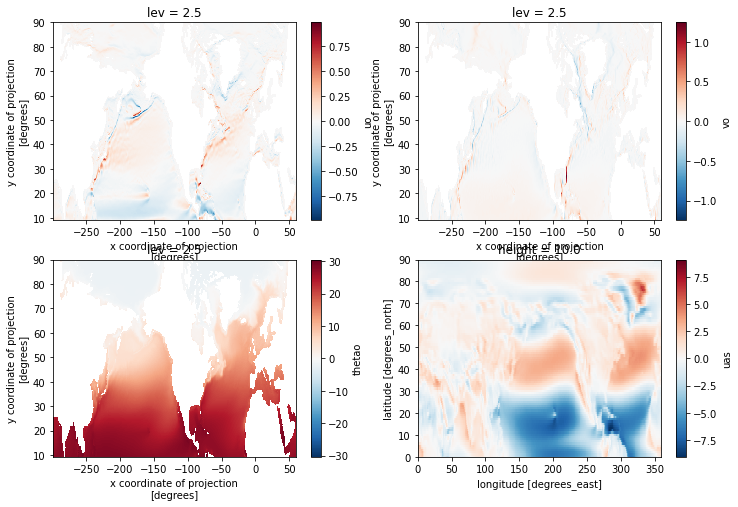

In [3]:
fig = plt.figure(figsize=(12, 8))

plt.subplot(221)
dsu.uo[:, 0, 540:, :].mean('time').plot()

plt.subplot(222)
dsv.vo[:, 0, 540:, :].mean('time').plot()

plt.subplot(223)
dst.thetao[:, 0, 540:, :].mean('time').plot()

plt.subplot(224)
dsws.uas[:, 90:, :].mean('time').plot()

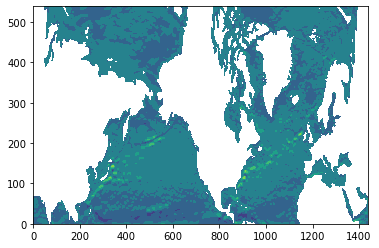

In [34]:
plt.contourf(dsu.uo[-1, 0, 540:, :])

In [6]:
xx, yy = np.meshgrid(dsu.x, dsu.y)

dx2d = np.zeros((1080, 1440))
dy2d = np.zeros((1080, 1440))

dx2d[:, :-1] = gsw.distance(xx, yy, 0) 
dy2d[:, :-1] = gsw.distance(yy, xx, 0)
dx2d[:, -1] = dx2d[:, -2]
dy2d[:, -1] = dy2d[:, -2]

In [7]:
dz = dsu.lev_bnds[:, 1] - dsu.lev_bnds[:, 0]

dz3d = np.zeros((35, 1080, 1440))
dz2d = np.zeros((35, 1080))
for i in np.arange(1080):
    dz2d[:, i] = dz
for i in np.arange(1440):
    dz3d[:, :, i] = dz2d

In [18]:
psi1 = np.zeros((240, 540, 600))
psi2 = np.zeros((240, 540, 400))

for tt in np.arange(240):
    
    psi1[tt, :, :] = ((dsv.vo[tt, :, 540:, 200:800] * dz3d[:, 540:, 200:800]).sum('lev') * dx2d[540:, 200:800]).cumsum('x') / 10**6
    psi2[tt, :, :] = ((dsv.vo[tt, :, 540:, 800:1200] * dz3d[:, 540:, 800:1200]).sum('lev') * dx2d[540:, 800:1200]).cumsum('x') / 10**6

    #psi1[tt, :, :] = ((dsv.vo[tt, :26, 540:, :] * dz3d[:26, 540:, :]).sum('lev') * dx2d[540:, :]).cumsum('x') / 10**6
    #psi2[tt, :, :] = ((dsu.uo[tt, :26, 540:, :] * dz3d[:26, 540:, :]).sum('lev') * dy2d[540:, :]).cumsum('y') / 10**6

In [21]:
psi2.shape

(240, 540, 400)

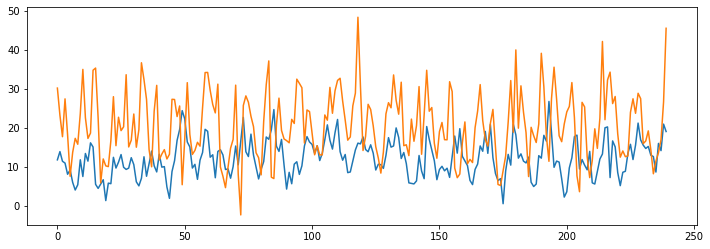

In [33]:
plt.figure(figsize=(12, 4))
plt.plot(np.mean(psi2[:, 50:150, 150], 1))
plt.plot(np.mean(psi1[:, 50:150, 150], 1))

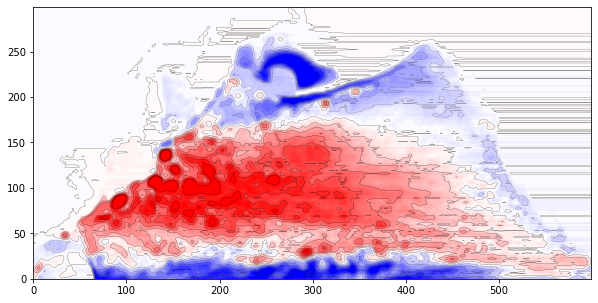

In [28]:
plt.figure(figsize=(10, 5))
plt.contourf(psi1[-1, :300, :], levels=np.arange(-60, 60.1, 2), cmap='bwr', extend='both')
plt.contour(psi1[-1, :300, :], levels=np.arange(-60, 60.1, 10), colors='k', linewidths=0.2)

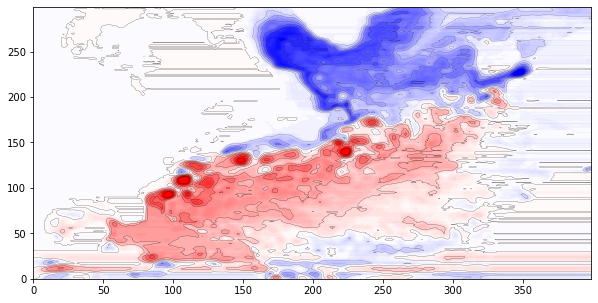

In [29]:
plt.figure(figsize=(10, 5))
plt.contourf(psi2[-1, :300, :], levels=np.arange(-60, 60.1, 2), cmap='bwr', extend='both')
plt.contour(psi2[-1, :300, :], levels=np.arange(-60, 60.1, 10), colors='k', linewidths=0.2)

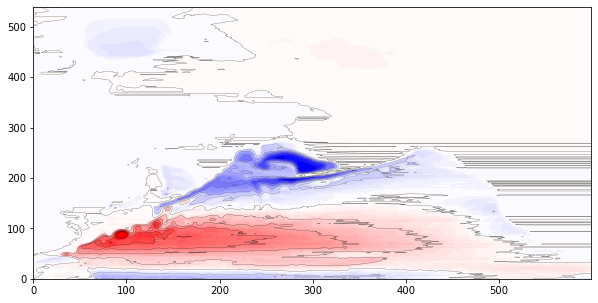

In [25]:
plt.figure(figsize=(10, 5))
plt.contourf(np.nanmean(psi1, axis=0), levels=np.arange(-60, 60.1, 2), cmap='bwr', extend='both')
plt.contour(np.nanmean(psi1, axis=0), levels=np.arange(-60, 60.1, 10), colors='k', linewidths=0.2)

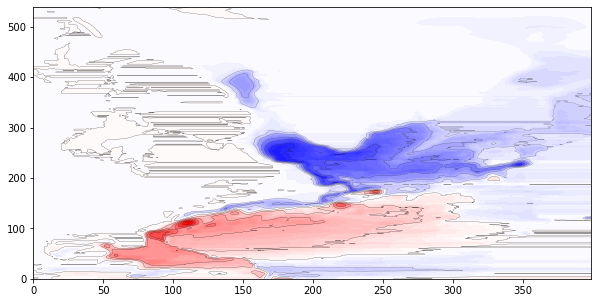

In [23]:
plt.figure(figsize=(10, 5))
plt.contourf(np.nanmean(psi2, axis=0)[:, :], levels=np.arange(-60, 60.1, 2), cmap='bwr', extend='both')
plt.contour(np.nanmean(psi2, axis=0)[:, :], levels=np.arange(-60, 60.1, 10), colors='k', linewidths=0.2)

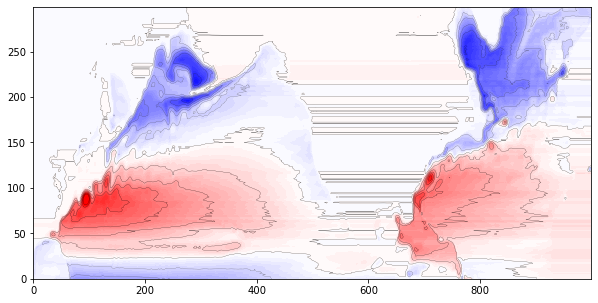

In [9]:
plt.figure(figsize=(10, 5))
plt.contourf(np.nanmean(psi1, axis=0)[:300, :], levels=np.arange(-60, 60.1, 2), cmap='bwr', extend='both')
plt.contour(np.nanmean(psi1, axis=0)[:300, :], levels=np.arange(-60, 60.1, 10), colors='k', linewidths=0.2)


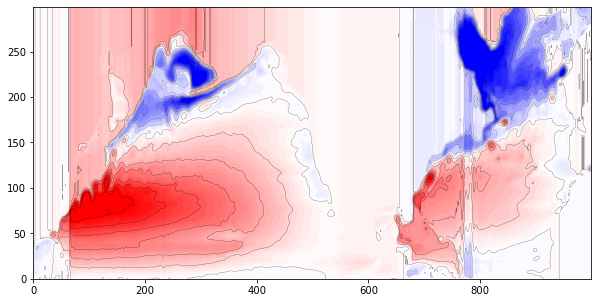

In [40]:
plt.figure(figsize=(10, 5))
plt.contourf(np.nanmean(-psi2, axis=0)[:300, 200:1200], levels=np.arange(-60, 60.1, 2), cmap='bwr', extend='both')
plt.contour(np.nanmean(-psi2, axis=0)[:300, 200:1200], levels=np.arange(-60, 60.1, 10), colors='k', linewidths=0.2)

In [59]:
vna = dsv.vo[:, :, 540:, 800:1300].mean('time').mean('x')

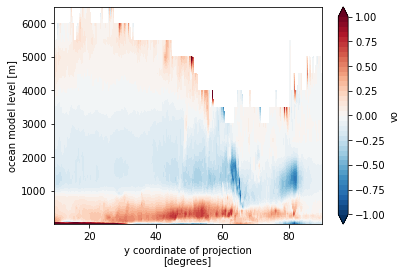

In [60]:
(vna*100).plot.contourf(levels=np.arange(-1, 1.01, 0.05))

In [61]:
vna = dsv.vo[:, :, 540:, 200:700].mean('time').mean('x')

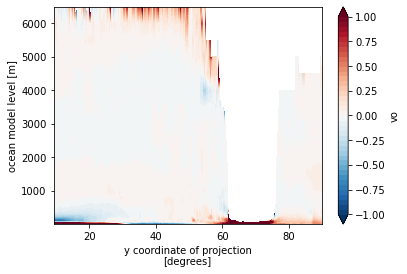

In [62]:
(vna*100).plot.contourf(levels=np.arange(-1, 1.01, 0.05))

In [65]:
datadir = '/data/home/liutongya/data/CMIP6/GFDL_CM4/thetao/thetao_Omon_GFDL-CM4_historical_r1i1p1f1_gn_199001-200912.nc'
ds = xr.open_dataset(datadir)
ds

<xarray.Dataset>
Dimensions:    (bnds: 2, lev: 35, time: 240, vertex: 4, x: 1440, y: 1080)
Coordinates:
  * bnds       (bnds) float64 1.0 2.0
  * time       (time) object 1990-01-16 12:00:00 ... 2009-12-16 12:00:00
  * x          (x) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * y          (y) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
  * lev        (lev) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
    lon        (y, x) float32 ...
    lat        (y, x) float32 ...
Dimensions without coordinates: vertex
Data variables:
    thetao     (time, lev, y, x) float32 ...
    time_bnds  (time, bnds) object ...
    lev_bnds   (lev, bnds) float64 ...
    lat_bnds   (y, x, vertex) float32 ...
    lon_bnds   (y, x, vertex) float32 ...
Attributes:
    title:                  NOAA GFDL GFDL-CM4 model output prepared for CMIP...
    external_variables:     areacello volcello
    history:                File was processed by fremetar (GFDL analog of CM...
    table_id:               Omon
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    comment:                <null ref>
    contact:                gfdl.climate.model.info@noaa.gov
    Conventions:            CF-1.7 CMIP-6.0 UGRID-1.0
    creation_date:          2019-02-23T17:36:39Z
    data_specs_version:     01.00.27
    experiment:             historical
    experiment_id:          historical
    forcing_index:          1
    frequency:              mon
    further_info_url:       https://furtherinfo.es-doc.org/CMIP6.NOAA-GFDL.GF...
    grid:                   ocean data on native grid tripolar - nominal 0.25...
    grid_label:             gn
    initialization_index:   1
    institution:            National Oceanic and Atmospheric Administration, ...
    institution_id:         NOAA-GFDL
    license:                CMIP6 model data produced by NOAA-GFDL is license...
    mip_era:                CMIP6
    nominal_resolution:     25 km
    parent_activity_id:     CMIP
    parent_experiment_id:   piControl
    parent_mip_era:         CMIP6
    parent_source_id:       GFDL-CM4
    parent_variant_label:   r1i1p1f1
    physics_index:          1
    product:                model-output
    realization_index:      1
    realm:                  ocean
    source:                 GFDL-CM4 (2018): \naerosol: interactive\natmos: G...
    source_id:              GFDL-CM4
    source_type:            AOGCM
    sub_experiment:         none
    sub_experiment_id:      none
    tracking_id:            hdl:21.14100/0386fd37-a918-4999-b88c-628e185866d9
    variable_id:            thetao
    variant_info:           N/A
    references:             see further_info_url attribute
    variant_label:          r1i1p1f1
    branch_time_in_parent:  36500.0
    parent_time_units:      days since 0001-1-1

In [66]:
tna = ds.thetao[:, :, 540:, 800:1300].mean('time').mean('x')

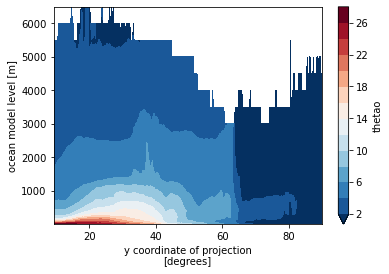

In [70]:
tna.plot.contourf(levels=np.arange(2, 30, 2))

In [71]:
tna = ds.thetao[:, :, 540:, 200:700].mean('time').mean('x')

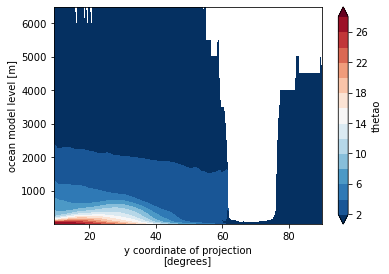

In [72]:
tna.plot.contourf(levels=np.arange(2, 30, 2))

In [25]:
ds.lev_bnds[:, 1]

<xarray.DataArray 'lev_bnds' (lev: 35)>
array([5.000e+00, 1.500e+01, 2.500e+01, 4.000e+01, 6.250e+01, 8.750e+01,
       1.125e+02, 1.375e+02, 1.750e+02, 2.250e+02, 2.750e+02, 3.500e+02,
       4.500e+02, 5.500e+02, 6.500e+02, 7.500e+02, 8.500e+02, 9.500e+02,
       1.050e+03, 1.150e+03, 1.250e+03, 1.350e+03, 1.450e+03, 1.625e+03,
       1.875e+03, 2.250e+03, 2.750e+03, 3.250e+03, 3.750e+03, 4.250e+03,
       4.750e+03, 5.250e+03, 5.750e+03, 6.250e+03, 6.750e+03])
Coordinates:
    bnds     float64 2.0
  * lev      (lev) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03

In [19]:
ds.lev

<xarray.DataArray 'lev' (lev: 35)>
array([2.5000e+00, 1.0000e+01, 2.0000e+01, 3.2500e+01, 5.1250e+01, 7.5000e+01,
       1.0000e+02, 1.2500e+02, 1.5625e+02, 2.0000e+02, 2.5000e+02, 3.1250e+02,
       4.0000e+02, 5.0000e+02, 6.0000e+02, 7.0000e+02, 8.0000e+02, 9.0000e+02,
       1.0000e+03, 1.1000e+03, 1.2000e+03, 1.3000e+03, 1.4000e+03, 1.5375e+03,
       1.7500e+03, 2.0625e+03, 2.5000e+03, 3.0000e+03, 3.5000e+03, 4.0000e+03,
       4.5000e+03, 5.0000e+03, 5.5000e+03, 6.0000e+03, 6.5000e+03])
Coordinates:
  * lev      (lev) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
Attributes:
    long_name:    ocean model level
    units:        m
    axis:         Z
    positive:     down
    description:  generic ocean model vertical coordinate (nondimensional or ...
    bounds:       lev_bnds

In [16]:
ds.uo[:, 0, 600:, :].mean('time')

<xarray.DataArray 'uo' (y: 480, x: 1440)>
array([[ 0.00208974,  0.01318619,  0.02485314, ..., -0.00473297,
        -0.00597553, -0.0025198 ],
       [ 0.00344557,  0.01235903,  0.02105495, ..., -0.00323959,
        -0.00391112, -0.00188534],
       [ 0.00328802,  0.01118106,  0.021007  , ..., -0.02077076,
        -0.01149204, -0.00229859],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]], dtype=float32)
Coordinates:
  * x        (x) float64 -299.7 -299.5 -299.2 -299.0 ... 59.28 59.53 59.78 60.03
  * y        (y) float64 23.56 23.79 24.01 24.24 ... 89.62 89.73 89.84 89.95
    lev      float64 2.5
    lon      (y, x) float32 ...
    lat      (y, x) float32 ...

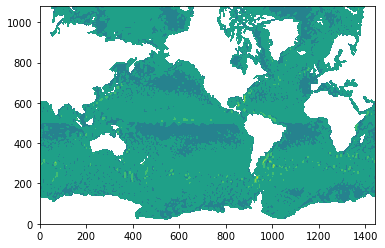

In [58]:
plt.contourf(dsv.vo[-1, 0, :, :])

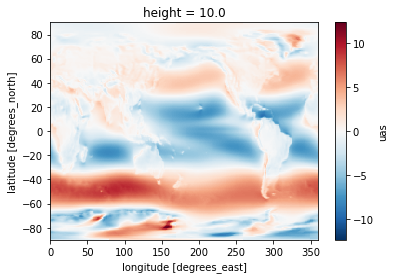

In [34]:
ds.uas.mean('time').plot()